## Introduction

Alternative task

Problematic word

Problems

Visual corrections

Negative samples

Balancing

Merging of the corpora

## TSA task

Intro

Problematic verb.

### Creating dictionary


First, let's define the list of corpora we will use in our bundle. Assume we have three corpora: news, publicistics and books.

In [1]:
from tg.grammar_ru import Loc

corpora = [
    Loc.corpus_path/'books.base.zip',
    Loc.corpus_path/'pub.base.zip'
]

Not every sentence in the corpora contains problematic word, so first we need to detect the sentences that are required in the bundle. For this particular task we will use a dictionary approach: we will scan the corpora and find verbs that are presented there in both -тся and -ться forms.

In [3]:
from yo_fluq_ds import *

good_words = set(FileIO.read_json('tsa-dict.json'))

### Building negative samples


First, we need a filter that will select the problematic sentences. We will use the filter that selects only the sentences with the words from the given dictionary. To view its functionality, we will create a demonstration dataframe:


In [ ]:
from tg.grammar_ru import Separator
from tg.grammar_ru.tasks.alternative import DictionaryFilterer

df = Separator.separate_string('Мне нравится борщ. Он вкусный.')
tsa_filter = DictionaryFilterer(good_words)
tsa_filter.filter(df)

As we can see, only the first sentences is included. Also, there is `is_target` column that indicates if the word is problematic.

 We need to build negative samples: the original sentence where the right word was replace with erroneous.

In [ ]:
from tg.grammar_ru.tasks.alternative import EndingNegativeSampler

df = Separator.separate_string('Мне нравится борщ. И не нравится рассольник.')
df = tsa_filter.filter(df)
tsa_sampler = EndingNegativeSampler('тся','ться')
tsa_sampler.build_negative_sample_from_positive(df)

But what if we have two problematic words in the same sentence?

In [ ]:
df = Separator.separate_string('Мне нравится борщ, а рассольник не нравится.')
df = tsa_filter.filter(df)
tsa_sampler.build_negative_sample_from_positive(df)

So, if two or more problematic words are contained in the sentence, in the resulting dataset all of them will be either correct or erroneous. This is imperfect, as it does not reflect the way we make errors in the texts. So, another method is introduced to correct that:

In [ ]:
df = Separator.separate_string('Мне нравится борщ, а рассольник не нравится.')
df = tsa_filter.filter(df)
pd.concat(tsa_sampler.build_all_negative_samples_from_positive(df))

## Balancing dataset


We want an equal representation of the sentences of different lengths, as well as sentences from different corpora. To do this, we will scan the corpora again, consider only the sentences that have a problematic word, and then compute the length of each such sentence.

In [ ]:
from tg.grammar_ru.ml.corpus import BucketBalancer

buckets_path = Path('tsa-buckets.parquet')

if not buckets_path.is_file():
    en = CorpusReader.read_frames_from_several_corpora(corpora).feed(fluq.with_progress_bar()).select(tsa_filter.filter)
    buckets_df = BucketBalancer.collect_buckets(en)
    buckets_df.to_parquet(buckets_path)
else:
    buckets_df = pd.read_parquet(buckets_path)


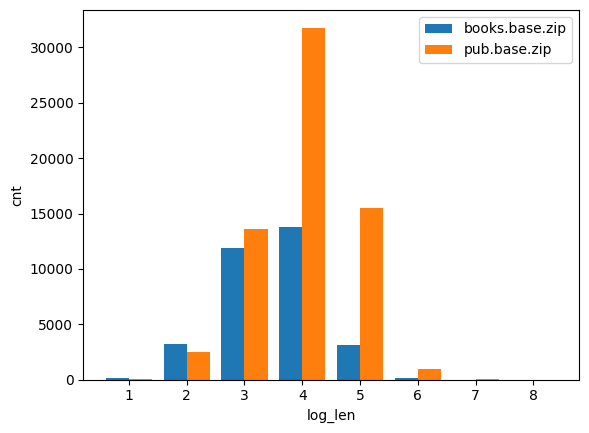

In [ ]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

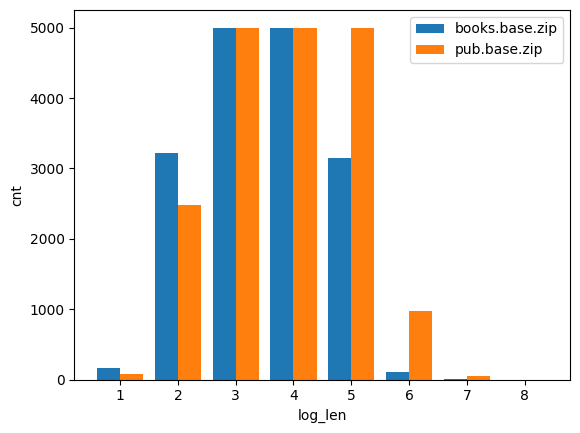

In [ ]:
import numpy as np
take_df = buckets_df
take_df['random'] = np.random.rand(take_df.shape[0])
take_df = take_df.feed(fluq.add_ordering_column(['corpus_id','log_len'],'random'))
take_df = take_df.loc[take_df.order<5000]


ax = grbar_plot(
    take_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()


Let's convert `take_df` into simpler format for `BucketBalancer`, and create a balancer:

In [ ]:
tsa_balancer = BucketBalancer(BucketBalancer.buckets_statistics_to_dict(take_df))
str(tsa_balancer.buckets)[:100]

"{'books.base.zip': {7929858, 9699332, 10551300, 33128454, 19660807, 25460744, 33128457, 4915211, 491"

At this point, we are ready to perform transfusion. Transfusion is an operation that reads the corpora, samples the sentences and creates a new corpus with these selected sentences. Along the way it also correct all the ids, thus making sure the merged corpus is consistant.


The next step is to enrich the corpus with features. This can also be done with `CorpusBuilder`:

Now we have all the information in the corpus format. We need to assemble this in bundle format: concatenate all the separate frames from `src`, `pymorphy` and other frames:

And finally, we need to create an index frame. This is usually just a subset of `src` frame:

## CHTOBY task

Intro

Problem: purely technical, how to replace several words, not one.

In [11]:
from tg.grammar_ru.tasks.alternative import WordSequenceFilterer

df = Separator.separate_string('Что бы поделать, чтобы не скучать')
chtoby_filter = WordSequenceFilterer([['чтобы'], ['что','бы']])

chtoby_filter.filter(df)

In [12]:
from tg.grammar_ru.tasks.alternative import WordPairsNegativeSampler
df = Separator.separate_string('Что бы поделать, чтобы не скучать')
df = chtoby_filter.filter(df)

chtoby_sampler = WordPairsNegativeSampler([('чтобы', 'что бы'), ('Чтобы', 'Что бы')])

chtoby_sampler.build_negative_sample_from_positive(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Чтобы,ru,23,True
1,1,0,1,0,0,поделать,ru,8,False
2,2,0,2,0,1,",",punct,1,False
3,3,0,3,0,1,что,ru,21,True
4,4,0,4,0,1,бы,ru,2,False
5,5,0,5,0,1,не,ru,2,False
6,6,0,6,0,0,скучать,ru,7,False


In [13]:
pd.concat(chtoby_sampler.build_all_negative_samples_from_positive(df))

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Чтобы,ru,23,True
1,1,0,1,0,0,поделать,ru,8,False
2,2,0,2,0,1,",",punct,1,False
3,3,0,3,0,1,чтобы,ru,5,False
4,4,0,4,0,1,не,ru,2,False
5,5,0,5,0,0,скучать,ru,7,False
0,0,0,0,0,1,Что,ru,3,False
1,1,0,1,0,1,бы,ru,2,False
2,2,0,2,0,0,поделать,ru,8,False
3,3,0,3,0,1,",",punct,1,False
